In [36]:
import pandas as pd
import numpy as np
from scipy import stats
import yaml
import os

yaml_path = "../configs/base.yaml"
with open(yaml_path, "r") as f:
    config = yaml.safe_load(f)

base_dir = os.path.dirname(os.getcwd())  
full_path = os.path.join(base_dir, config["data"]["raw_NQ"])
data_NQ = pd.read_csv(full_path)
data_NQ_close = pd.to_numeric(data_NQ["Close"], errors="coerce")

In [37]:
def rsi(series: pd.Series, period: int = 2) -> pd.Series:
    delta = series.diff()  # computes daily returns
    gain = delta.clip(lower=0)  # positive returns
    loss = -delta.clip(upper=0)  # negative returns

    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    RSI = RSI.fillna(0)

    return RSI


def hurst_local(series: pd.Series) -> float:
    ts = np.asarray(series, dtype=float)  
    N = len(ts)
    if N < 8:
        return np.nan

    max_window = N // 2

    window_sizes = np.unique(
        np.floor(
            np.logspace(np.log10(4), np.log10(max_window), num=10)
        ).astype(int)
    )

    RS_vals = []
    used_window_sizes = []  

    for w in window_sizes:
        if w >= N:
            continue
        n_segments = N // w
        RS_seg = []
        for i in range(n_segments):
            seg = ts[i*w:(i+1)*w]  
            seg = seg - np.mean(seg)  
            Y = np.cumsum(seg)  
            R = np.max(Y) - np.min(Y)  
            S = np.std(seg)  
            if S != 0:
                RS_seg.append(R/S)
        if RS_seg:
            RS_vals.append(np.mean(RS_seg))
            used_window_sizes.append(w)

    if len(RS_vals) < 2:
        return np.nan

    lx = np.log10(used_window_sizes)
    ly = np.log10(RS_vals)
    slope, _, _, _, _ = stats.linregress(lx, ly)
    return slope


def hurst_exponent(series: pd.Series, window: int = 20) -> pd.Series:
    H = series.rolling(window).apply(lambda x: hurst_local(x), raw=False)
    return H


def composite_rsi(series: pd.Series, short: int, long: int) -> pd.Series:
    short_rsi = rsi(series, short)
    comp_rsi = short_rsi.ewm(span=long, adjust=False).mean()  # EWMA smoothing
    return comp_rsi



NQ_RSI = rsi(data_NQ_close, period=2)
NQ_Hurst = hurst_exponent(data_NQ_close, window=20)
NQ_composite_RSI = composite_rsi(data_NQ_close, short=2, long=24)

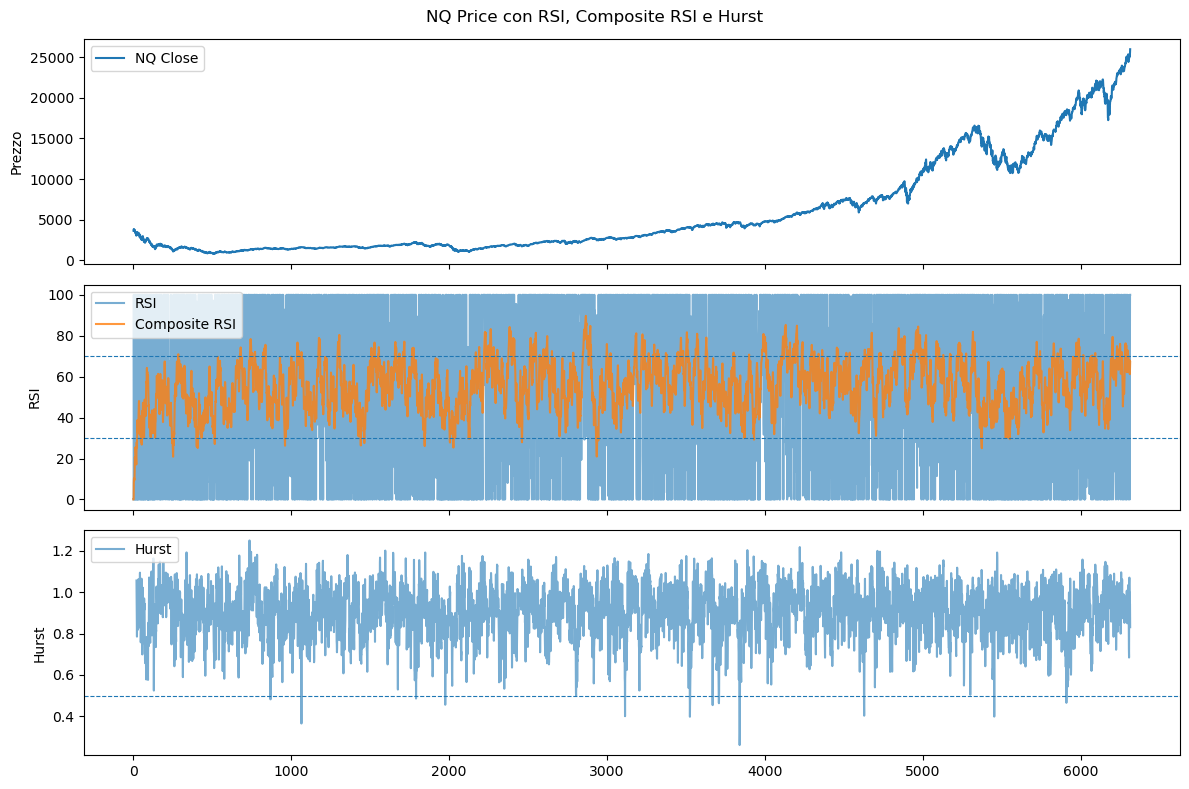

In [ ]:
import matplotlib.pyplot as plt

fig, (ax_price, ax_rsi, ax_hurst) = plt.subplots(
    3, 1, figsize=(12, 8), sharex=True
)


# PRICE
ax_price.plot(data_NQ["Close"], label="NQ Close")
ax_price.set_ylabel("Prezzo")
ax_price.legend(loc="upper left")

# RSI 
ax_rsi.plot(NQ_RSI, label="RSI", alpha=0.6)
ax_rsi.plot(NQ_composite_RSI, label="Composite RSI", alpha=0.8)
ax_rsi.set_ylabel("RSI")
ax_rsi.axhline(30, linestyle="--", linewidth=0.8) 
ax_rsi.axhline(70, linestyle="--", linewidth=0.8)  
ax_rsi.legend(loc="upper left")

# HURST
ax_hurst.plot(NQ_Hurst, label="Hurst", alpha=0.6)
ax_hurst.set_ylabel("Hurst")
ax_hurst.axhline(0.5, linestyle="--", linewidth=0.8)  
ax_hurst.legend(loc="upper left")

plt.suptitle("NQ Price con RSI, Composite RSI e Hurst")
plt.tight_layout()
plt.show()